Testing some MDS solutions on the data
===

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from glob import glob
from sklearn.metrics import r2_score
import pandas as pd
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances


rock_images_glob = "120 Rock Images/*.png"
rock_images = glob(rock_images_glob)
rock_images.sort() # get them in the right order

judgements_glob = "Similarity Judgments Data/rocks_similarity_120_*.txt"
judgements_files = glob(judgements_glob)

mds_file = "MDS/mds_120_supplemental_dims.txt"

## Plot functions

In [3]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def imscatter(x, y, image, ax=None, zoom=1):
    """
    Creates scatter with image file
    """
    
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    
    return artists

def plot_compare_dims(dim_a, dim_b, mds_obs, mds_obs_2, rock_images):
    """
    Plots rocks for given dimensions
    """
    fig = plt.figure(figsize = (12, 6))

    # plot 1
    ax_1 = plt.subplot(1, 2, 1)
    for i, rock in enumerate(rock_images):
        imscatter(mds_obs[i, dim_a-1], mds_obs[i, dim_b-1], rock, zoom = 0.033, ax=ax_1)
    ax_1.set_xlabel(f"MDS Dimension {dim_a}")
    ax_1.set_ylabel(f"MDS Dimension {dim_b}")
    ax_1.set_title("MDS coordinates Sanders & Nosofsky (2020)")

    # plot 2
    ax_2 = plt.subplot(1, 2, 2)
    for i, rock in enumerate(rock_images):
        imscatter(mds_obs_2[i, dim_a-1], mds_obs_2[i, dim_b-1], rock, zoom = 0.033, ax=ax_2)
    ax_2.set_xlabel(f"MDS Dimension {dim_a}")
    ax_2.set_title("MDS coordinates replication")
    
    plt.tight_layout()
    
    return None


## Original MDS coordinates

In [4]:
# original MDS coordinates for 120 Rocks Set
mds_obs = np.loadtxt(mds_file, skiprows=1)

print("Number of rocks:     ", np.shape(mds_obs)[0])
print("Number of dimensions:", np.shape(mds_obs)[1])

Number of rocks:      120
Number of dimensions: 13


## Replicated MDS coordinates with scikit-learn

In [5]:
# replicated MDS coordinates for 120 Rocks Set

seed = 3

# load judgements into 1 dataframe
df_jm = pd.read_csv(judgements_files[0], sep="\s+")
df_jm['Rater'] = int(judgements_files[0].split('_')[-1].replace('.txt', ''))

for jf in judgements_files:

    tmp = pd.read_csv(jf, sep="\s+")
    tmp['Rater'] = int(jf.split('_')[-1].replace('.txt', ''))
    df_jm = pd.concat([df_jm, tmp], sort=False).reset_index(drop=True)

df_jm = df_jm.sort_values(['Rater', 'Rock1Type', 'Rock2Type']).reset_index(drop=True)
df_jm['Rock1'] = df_jm['Rock1Type'].astype(str).str.pad(2,fillchar='0') + '_' + df_jm['Rock1Token'].astype(str).str.pad(2,fillchar='0')
df_jm['Rock2'] = df_jm['Rock2Type'].astype(str).str.pad(2,fillchar='0') + '_' + df_jm['Rock2Token'].astype(str).str.pad(2,fillchar='0')
df_jm = df_jm.drop(['Rock1Type', 'Rock2Type', 'Rock1Token', 'Rock2Token'], axis = 1)
df_jm = df_jm.reindex(columns=['Rater', 'Rock1', 'Rock2', 'Rating'])

# sorting pairs
df_jm[['Rock1', 'Rock2']] = np.sort(df_jm[['Rock1', 'Rock2']].values)

df_jm_grp = df_jm.groupby(['Rock1', 'Rock2']).mean().drop('Rater', axis=1).reset_index()

# make unique, sorted, common index
idx = sorted(set(df_jm_grp['Rock1']).union(df_jm_grp['Rock2']))

# reshape
df_dist = (df_jm_grp.pivot(index='Rock1', columns='Rock2', values='Rating')
    .reindex(index=idx, columns=idx)
    .fillna(0, downcast='infer')
    .pipe(lambda x: x+x.values.T))

# compute distances
m_dist = euclidean_distances(df_dist)

#categories = [cat[:2] for cat in df_dist.index]

# metric = False leads to poor not meaningful results
m = MDS(n_components=8, metric=True, dissimilarity='precomputed', random_state=seed)

# Get the embeddings
mds_repl = m.fit_transform(m_dist)

# Standard scale the solution
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((-5, 5))
mds_repl = scaler.fit_transform(mds_repl)


print("Number of rocks:     ", np.shape(mds_repl)[0])
print("Number of dimensions:", np.shape(mds_repl)[1])

Number of rocks:      120
Number of dimensions: 8


### Try to find similar solution to original by combinating ...
... different seeds and dimension orders and correlate these solutions with the original mds coordinates

In [6]:
from itertools import permutations
  
dim_permutations = permutations(range(1, 9), 8)
dim_permutations = np.array(list(dim_permutations))

In [7]:
best_seed = 57 # Checked until seed 100
best_value = 0.43555698171695534
best_combination = [4, 7, 5, 2, 3, 8, 6, 1]

In [10]:
from scipy.stats import pearsonr

for seed in range(100, 125):
    
    # metric=False seems to lead to non-meaningful results ... Have to check this in the documentation
    m = MDS(n_components=8, metric=True, dissimilarity='precomputed', random_state=seed)
    mds_repl = m.fit_transform(m_dist)
    scaler = MinMaxScaler((-5, 5))
    mds_repl = scaler.fit_transform(mds_repl)
    
    for j in range(0, len(dim_permutations)):
        dim_repl = dim_permutations[j, ]
        rs = []
        for i in range(8):
            r, _ = pearsonr(mds_obs[:, i], mds_repl[:, dim_repl[i]-1], ) 
            rs.append(r)

        if np.mean(rs) > best_value:
            best_seed = seed 
            best_value = np.mean(rs) 
            best_combination = dim_repl
            print(best_seed,": ", best_value, ", Dim repl: ", best_combination, sep="")
            

print("\n\nFinished.\n\n", best_seed,": ", best_value, ", Dim repl: ", best_combination, sep="")

32: 0.4257344112701128, Dim repl: [5 1 3 2 6 4 7 8]
57: 0.4271350210670018, Dim repl: [4 1 7 2 3 8 6 5]
57: 0.43555698171695534, Dim repl: [4 7 5 2 3 8 6 1]


Finished.

57: 0.43555698171695534, Dim repl: [4 7 5 2 3 8 6 1]


Recreate most similar configuration

In [14]:
# run mds
# metric=False seems to lead to non-meaningful results ... Have to check this in the documentation
m = MDS(n_components=8, metric=True, dissimilarity='precomputed', random_state=best_seed)
mds_repl = m.fit_transform(m_dist)
scaler = MinMaxScaler((-5, 5))
mds_repl = scaler.fit_transform(mds_repl)

# swap dimensions
mds_repl = mds_repl[:,  np.array(best_combination)-1]

# write to file
np.savetxt("MDS/mds_120_replication_sklearn.txt", mds_repl) # write to file

### Plot results

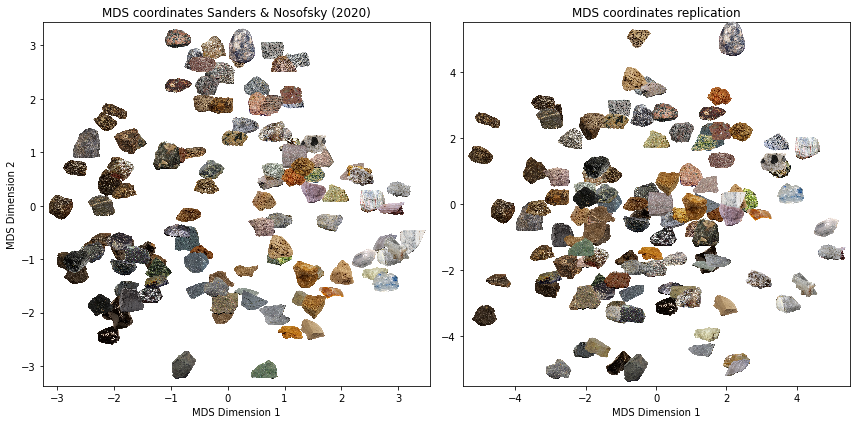

In [19]:
plot_compare_dims(1, 2, mds_obs, mds_repl, rock_images)

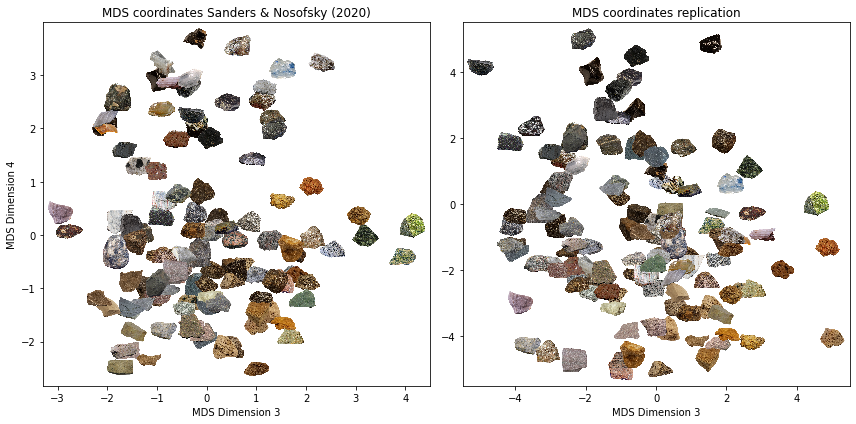

In [20]:
plot_compare_dims(3, 4, mds_obs, mds_repl, rock_images)

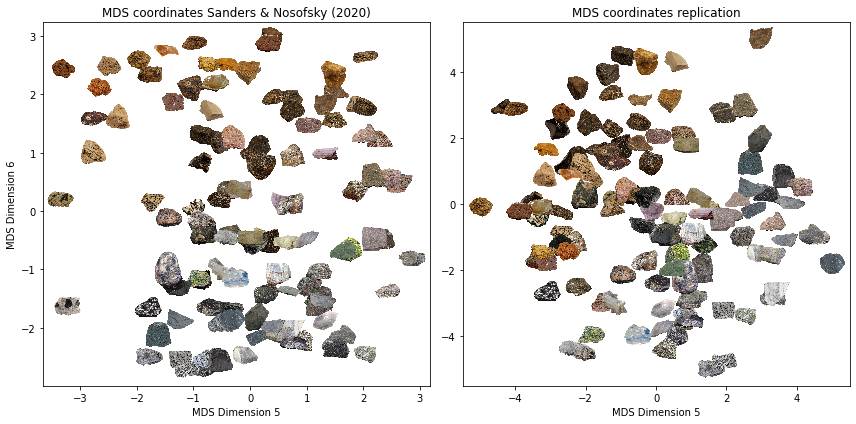

In [22]:
plot_compare_dims(5, 6, mds_obs, mds_repl, rock_images)

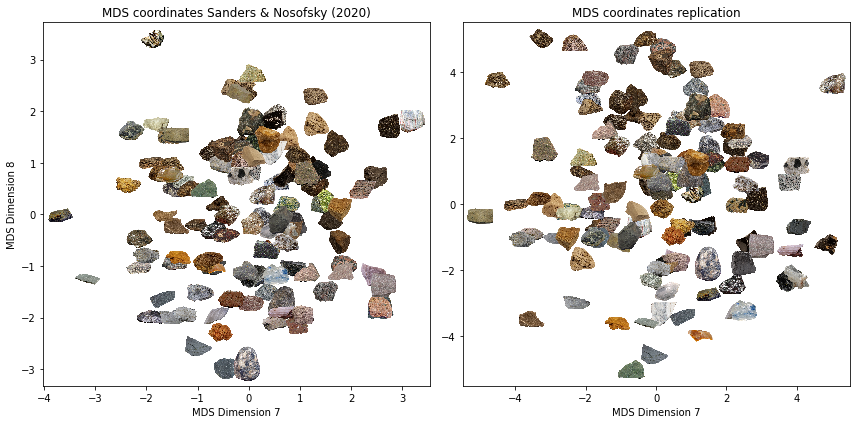

In [23]:
plot_compare_dims(7, 8, mds_obs, mds_repl, rock_images)

## Replication with R (smacof)

Computation done in file `mds_test_r.ipynb`

In [72]:
# in R replicated MDS coordinates for 120 Rocks Set
mds_r_file = "MDS/mds_120_replication_r.txt"
mds_repl_r = np.loadtxt(mds_r_file, skiprows=1)

print("Number of rocks:     ", np.shape(mds_repl_r)[0])
print("Number of dimensions:", np.shape(mds_repl_r)[1])

Number of rocks:      120
Number of dimensions: 8


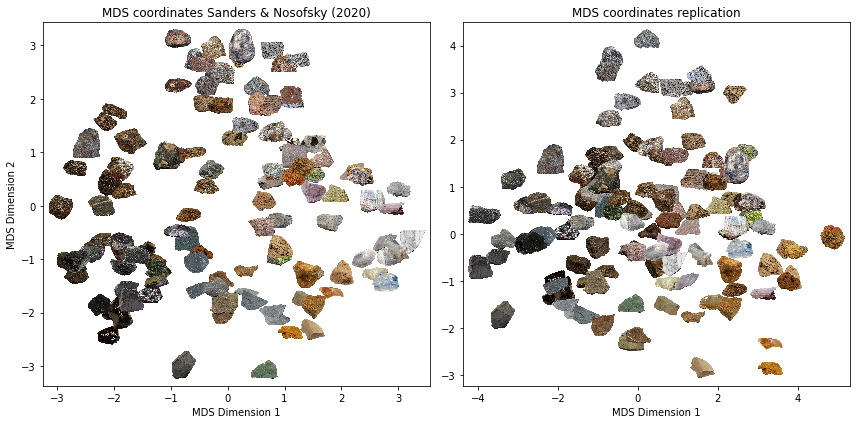

In [73]:
plot_compare_dims(1, 2, mds_obs, mds_repl_r, rock_images)

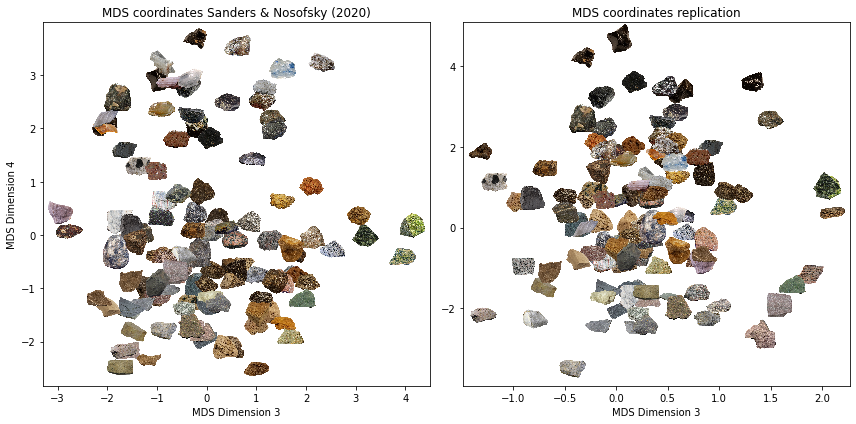

In [74]:
plot_compare_dims(3, 4, mds_obs, mds_repl_r, rock_images)

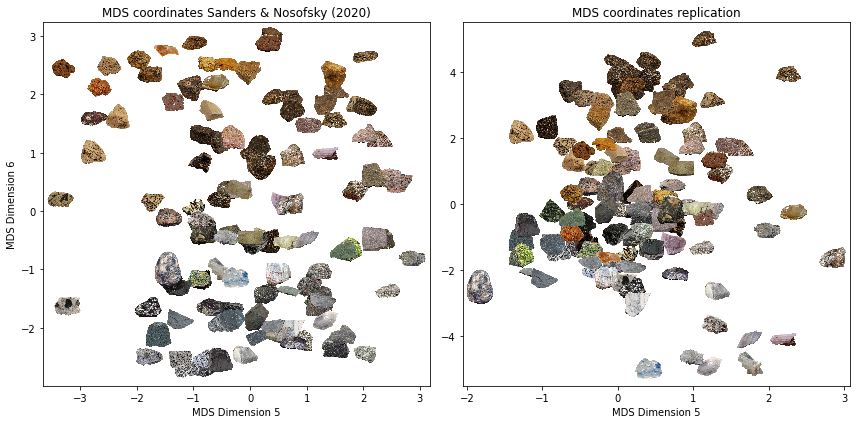

In [75]:
plot_compare_dims(5, 6, mds_obs, mds_repl_r, rock_images)

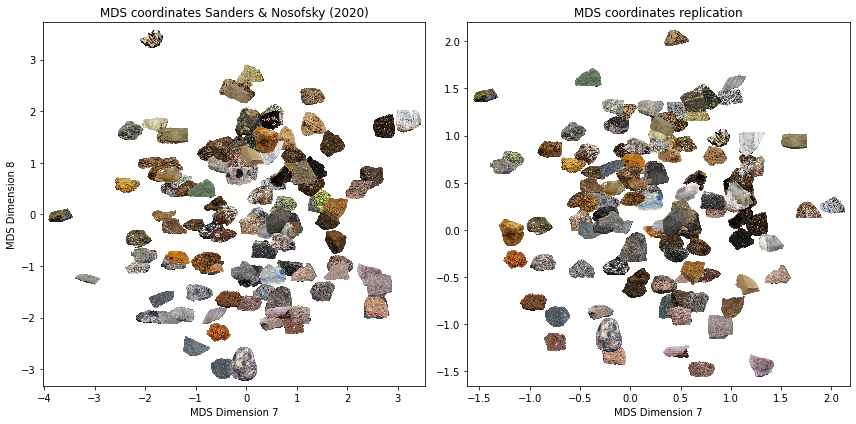

In [76]:
plot_compare_dims(7, 8, mds_obs, mds_repl_r, rock_images)